In [1]:
# データセット作成

!pip install scipy

window_size = 1024
window_num_per_clip = 40
clip_size = window_size * window_num_per_clip

from scipy.io.wavfile import read
import glob
import os
import numpy as np

def standardization(x):
    ret = np.log(x + 1) / np.log(np.finfo(np.float32).max)
    if (np.sum(ret) == 0):
        return ret
    else:
        return ret / np.sum(ret)

if os.path.isfile("../data/arrays/clips.npy"):
    print("clips.npy exists.")
    clips = np.load("../data/arrays/clips.npy")
else:
    files = glob.glob("../data/wav44100/*")
    #files = ["../data/wav44100/3DEmbodimentFromLines.wav"]
    raw_data_list = [read(file)[1] for file in files]

    clips = np.zeros((0, clip_size), dtype=np.int16)
    for raw_data in raw_data_list:
        tmp = [raw_data[i:i + clip_size] for i in range(0, len(raw_data) - clip_size, clip_size)]
        clips = np.vstack((clips, np.array(tmp)))
    np.save("../data/arrays/clips", clips)
    
print("clips.shape: " + str(clips.shape))
    
if os.path.isfile("../data/arrays/fft_log_normalized.npy"):
    print("fft_log_normalized.npy exists.")
    fft = np.load("../data/arrays/fft_log_normalized.npy")
else:
    fft = np.zeros((0, window_num_per_clip, window_size))
    num = 0
    for clip in clips:
        print("fft progress: clip " + str(num))
        
        fft_tmp = np.zeros((0, window_size))
        tmp = [clip[i:i + window_size] for i in range(0, len(clip) - window_size + 1, window_size)]
        for tmp2 in tmp:
            spectrum = np.abs(np.fft.fft(tmp2))
            spectrum = standardization(spectrum)
            fft_tmp = np.vstack((fft_tmp, spectrum))
        fft = np.vstack((fft, fft_tmp.reshape(1, window_num_per_clip, window_size)))
        num += 1

    np.save("../data/arrays/fft_log_normalized", fft)

print(fft.shape)
print(type(fft[0][0][0]))
print(clips.shape)

print(fft[0][0])

     |████████████████████████████████| 34.5 MB 17.2 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
clips.npy exists.
clips.shape: (28576, 40960)
fft_log_normalized.npy exists.
(28576, 40, 1024)
<class 'numpy.float64'>
(28576, 40960)
[0.0017106  0.00181047 0.00211305 ... 0.00209956 0.00211305 0.00181047]


In [2]:
# 学習データとテストデータに分ける

train_data_rate = 0.8

p = np.random.permutation(len(fft))
fft = fft[p]
clips = clips[p]

x_train = fft[:int(fft.shape[0] * train_data_rate), :, :].reshape((int(fft.shape[0] * train_data_rate), clip_size))
x_test = fft[int(fft.shape[0] * train_data_rate):-1, :, :].reshape((fft.shape[0] - int(fft.shape[0] * train_data_rate) - 1, clip_size))
y_train = fft[1:int(fft.shape[0] * train_data_rate) + 1, 0, :]
y_test = fft[int(fft.shape[0] * train_data_rate) + 1:, 0, :]

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

print(np.max(x_train[0]))

(22860, 40960)
(5715, 40960)
(22860, 1024)
(5715, 1024)
0.002429921869444164


In [3]:
def plot_history(history):
    # 精度の履歴をプロット
    plt.plot(history.history['accuracy'],"o-",label="accuracy")
    plt.plot(history.history['val_accuracy'],"o-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()
 
    # 損失の履歴をプロット
    plt.plot(history.history['loss'],"o-",label="loss",)
    plt.plot(history.history['val_loss'],"o-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='lower right')
    plt.show()

In [14]:
# モデル作成

import keras

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras.optimizers import Adam

learning_rate = 0.00001
 
model = keras.models.Sequential()
model.add(Dense(units=4096,input_dim=clip_size))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(units=4096,input_dim=clip_size))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1024))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=learning_rate),metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 4096)              167776256 
                                                                 
 activation_18 (Activation)  (None, 4096)              0         
                                                                 
 dropout_12 (Dropout)        (None, 4096)              0         
                                                                 
 dense_19 (Dense)            (None, 4096)              16781312  
                                                                 
 activation_19 (Activation)  (None, 4096)              0         
                                                                 
 dropout_13 (Dropout)        (None, 4096)              0         
                                                                 
 dense_20 (Dense)            (None, 1024)             

In [15]:
# 学習

history = model.fit(x_train, y_train,
                    batch_size=16,
                    epochs=100,
                    verbose=1,
                    validation_data=(x_test, y_test))

KeyboardInterrupt: 

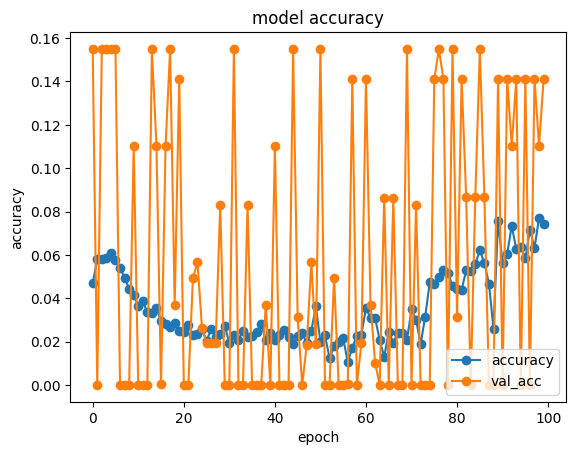

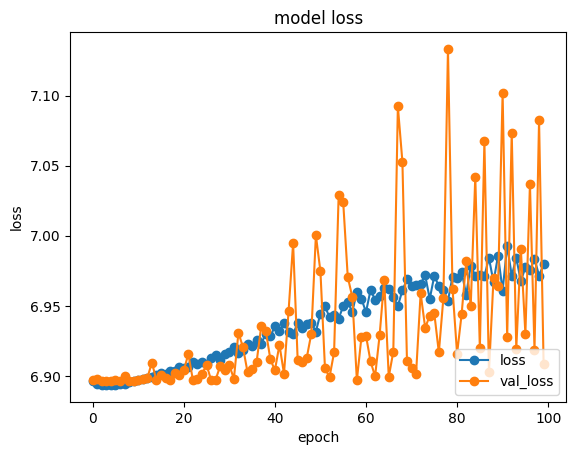

In [6]:
# loss 遷移のプロット

import matplotlib.pyplot as plt

plot_history(history)

In [7]:
# 楽曲の出力

!pip install scikit-learn

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from scipy.io import wavfile

first_index = 1000
predict_index = first_index
out = np.zeros((0, ), dtype=np.int16)

for i in range(10):
    predict = model.predict(fft[predict_index].reshape(1, clip_size))
    
    index = 0
    similar_index = 0
    cos_sim = np.inf
    for spectrum in fft[:, 0:1, :]:
        tmp_sim = cosine_similarity(predict, spectrum) 
        if cos_sim > tmp_sim:
            cos_sim = tmp_sim
            similar_index = index
        index += 1
    
    print(similar_index)
    
    predict_index = similar_index
    out = np.hstack((out, clips[predict_index]))
    
wavfile.write("../data/out/fft_out_1.wav", 44100, out)

first_index = 2000
predict_index = first_index
out = np.zeros((0, ), dtype=np.int16)

for i in range(10):
    predict = model.predict(fft[predict_index].reshape(1, clip_size))
    
    index = 0
    similar_index = 0
    cos_sim = np.inf
    for spectrum in fft[:, 0:1, :]:
        tmp_sim = cosine_similarity(predict, spectrum) 
        if cos_sim > tmp_sim:
            cos_sim = tmp_sim
            similar_index = index
        index += 1
    
    print(similar_index)
    
    predict_index = similar_index
    out = np.hstack((out, clips[predict_index]))
    
wavfile.write("../data/out/fft_out_2.wav", 44100, out)

first_index = 3000
predict_index = first_index
out = np.zeros((0, ), dtype=np.int16)

for i in range(10):
    predict = model.predict(fft[predict_index].reshape(1, clip_size))
    
    index = 0
    similar_index = 0
    cos_sim = np.inf
    for spectrum in fft[:, 0:1, :]:
        tmp_sim = cosine_similarity(predict, spectrum) 
        if cos_sim > tmp_sim:
            cos_sim = tmp_sim
            similar_index = index
        index += 1
    
    print(similar_index)
    
    predict_index = similar_index
    out = np.hstack((out, clips[predict_index]))
    
wavfile.write("../data/out/fft_out_3.wav", 44100, out)

     |████████████████████████████████| 9.8 MB 9.4 MB/s eta 0:00:01     |█████████████████████████████▏  | 8.9 MB 7.9 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 7.1 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
1/1 [==============================] - 0s 69ms/step
123
1/1 [==============================] - 0s 27ms/step
123
1/1 [==============================] - 0s 25ms/step
123
1/1 [==============================] - 0s 25ms/step
123
1/1 [==============================] - 0s 24ms/step
123
1/1 [==============================] - 0s 23ms/step
123
1/1 [==============================] - 0s 24ms/step
123
1/1 [==============================] - 0s 23ms/step
123
1/1 [==============================] - 0s 23ms/step
123
1/1 [==============================] - 0s 25ms/step
123
1/1 [==============================] - 0s 23ms/step
123
1/1 [==============================] - 0s 23ms/step
123
1/1 [=========================